The goal of this notebook is to implement a GNN learner to predict links between users and movies or in other words to recommend movies to a user.

- Medium (towards datascience): https://medium.com/stanford-cs224w/lightgcn-with-pytorch-geometric-91bab836471e
- Colab: https://colab.research.google.com/drive/1KKugoFyUdydYC0XRyddcROzfQdMwDcnO?usp=sharing#scrollTo=CS7HVr3qLQGx

The learning problem boils down to an edge prediction task in which we predict edges between nodes. We set this up as an homogeneous graph, where there is no distinction between user nodes and movie nodes. The edges in our data are modelled as interaction matrix. An edge represents a ratings of a users for a movie. It can be read as (user) -[rated]-> (movie). We need to transform the interaction matrix to an adjency matrix as shown below

<img src="files/InteractionToAdjecency.png" width="600" style="display=block; margin:auto"/>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from neo4j import GraphDatabase
from neo4_connection import USER, PWD, URL

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load data

In [3]:
driver = GraphDatabase.driver(uri=URL, auth=(USER, PWD))

def fetch_data(query):
  with driver.session() as session:
    result = session.run(query)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [4]:
query = """
MATCH (u:User) -[r:RATED]-> (m:Movie)
RETURN u.userId AS userId, 
    m.movieId AS movieId, 
    r.rating AS rating
ORDER BY userId, movieId
"""

df = fetch_data(query)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100004 non-null  int64  
 1   movieId  100004 non-null  int64  
 2   rating   100004 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [5]:
assert len(df) == 100004, 'Query did not return the expected 100004 records!'

In [6]:
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [7]:
df['rating'].value_counts()

4.0    28750
3.0    20064
5.0    15095
3.5    10538
4.5     7723
2.0     7271
2.5     4449
1.0     3326
1.5     1687
0.5     1101
Name: rating, dtype: int64

In [8]:
n_users = df['userId'].nunique()
n_movies = df['movieId'].nunique()
n_nodes = n_users + n_movies

print('# Users:', n_users)
print('# Movies:', n_movies)
print('# Nodes:', n_nodes)

# Users: 671
# Movies: 9066
# Nodes: 9737


## Preprocess Data

In [9]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
df['userId'] = user_encoder.fit_transform(df['userId'].values)
df['movieId'] = movie_encoder.fit_transform(df['movieId'].values)

df.describe().loc[['min', 'max']]

,userId,movieId,rating
min,0.0,0.0,0.5
max,670.0,9065.0,5.0


In [10]:
POSITIVE_THRESHOLD = 4
df_pos_samples = df[df['rating'] >= POSITIVE_THRESHOLD]
df_neg_samples = df[df['rating'] < POSITIVE_THRESHOLD]

print('# Positive samples:', len(df_pos_samples))
print('# Negative samples:', len(df_neg_samples))

# Positive samples: 51568
# Negative samples: 48436


In [11]:
df_train, df_val = train_test_split(df_pos_samples, test_size=0.2, random_state=33)
df_test, df_val = train_test_split(df_val, test_size=0.5, random_state=33)

print('Train:', df_train.shape)
print('Val:', df_val.shape)
print('Test:', df_test.shape)

Train: (41254, 3)
Val: (5157, 3)
Test: (5157, 3)


In [12]:
train_edge_index = torch.Tensor(df_train[['userId', 'movieId']].values).to(torch.long).swapaxes(1, 0)
val_edge_index = torch.Tensor(df_val[['userId', 'movieId']].values).to(torch.long).swapaxes(1, 0)
test_edge_index = torch.Tensor(df_test[['userId', 'movieId']].values).to(torch.long).swapaxes(1, 0)

print('Train edges:', train_edge_index.size())
print('Val edges:', val_edge_index.size())
print('Test edges:', test_edge_index.size())

Train edges: torch.Size([2, 41254])
Val edges: torch.Size([2, 5157])
Test edges: torch.Size([2, 5157])


In [13]:
# convert edge indices into Sparse Tensors: https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(n_nodes, n_nodes))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(n_nodes, n_nodes))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(n_nodes, n_nodes))

print('Train SparseTensor (Adj. Matrix):', train_sparse_edge_index)
print('Val SparseTensor (Adj. Matrix):', val_sparse_edge_index)
print('Test SparseTensor (Adj. Matrix):', test_sparse_edge_index)

Train SparseTensor (Adj. Matrix): SparseTensor(row=tensor([  0,   0,   0,  ..., 670, 670, 670]),
             col=tensor([ 931, 1515, 1665,  ..., 4412, 4417, 4597]),
             size=(9737, 9737), nnz=41254, density=0.04%)
Val SparseTensor (Adj. Matrix): SparseTensor(row=tensor([  1,   1,   1,  ..., 670, 670, 670]),
             col=tensor([  16,   37,  100,  ..., 3800, 3810, 4546]),
             size=(9737, 9737), nnz=5157, density=0.01%)
Test SparseTensor (Adj. Matrix): SparseTensor(row=tensor([  1,   1,   1,  ..., 670, 670, 670]),
             col=tensor([ 266,  315,  523,  ..., 2147, 2374, 4413]),
             size=(9737, 9737), nnz=5157, density=0.01%)


## Negative sampling

In [14]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size:int, edge_index:Tensor):
    """ Randomly samples indices of a minibatch given an adjacency matrix.

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)
    indices = random.choices(
        [i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

sample_mini_batch(4, train_edge_index)

(tensor([529, 547, 251, 640]),
 tensor([232, 498, 441, 121]),
 tensor([5517, 2774, 4221, 2701]))

## Model: Light GCN 

In [15]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users:int, num_items:int, embedding_dim:int=8, K:int=3, add_self_loops:bool=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

model = LightGCN(num_users=n_users, num_items=n_movies, embedding_dim=32)
model.users_emb.weight[[10, 12]]

tensor([[ 0.0575, -0.0525,  0.1055, -0.1097, -0.1091,  0.1444, -0.0529,  0.0435,
          0.2712, -0.0619, -0.1214, -0.0851, -0.1528,  0.0478, -0.1077, -0.1112,
          0.0326, -0.0127,  0.0210,  0.1632, -0.1000,  0.0599,  0.2465, -0.0082,
         -0.0936, -0.1190, -0.0160, -0.0679,  0.1039, -0.1608, -0.0124, -0.0162],
        [-0.1330,  0.0065,  0.1256,  0.0992, -0.0303, -0.2325, -0.0153, -0.0755,
         -0.0401, -0.0437, -0.0390, -0.0073,  0.0287, -0.1618, -0.0100,  0.0227,
          0.0029,  0.1275,  0.0953,  0.0420,  0.0176,  0.0060, -0.0549,  0.2384,
         -0.0186, -0.0182, -0.0204,  0.0057,  0.0918,  0.0134, -0.1610,  0.0522]],
       grad_fn=<IndexBackward0>)

## Loss function (PBR)

In [16]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

## Evaluation Metrics

In [17]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [18]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [19]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [20]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [21]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(
        sparse_edge_index)
    edges = structured_negative_sampling(
        edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

## Train

In [22]:
# define contants
ITERATIONS = 10000
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [23]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cpu.


In [24]:
# training loop
train_losses = []
val_losses = []

for iter in range(ITERATIONS):
    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)
    user_indices = user_indices.to(device)
    pos_item_indices = pos_item_indices.to(device)
    neg_item_indices = neg_item_indices.to(device)

    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}]\ttrain_loss: {round(train_loss.item(), 5)}\tval_loss: {round(val_loss, 5)} \
            \tval_recall@{K}: {round(recall, 5)}\tval_precision@{K}: {round(precision, 5)}\tval_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

[Iteration 0/10000]	train_loss: -0.69226	val_loss: -0.68817             	val_recall@20: 0.00097	val_precision@20: 0.00058	val_ndcg@20: 0.001
[Iteration 200/10000]	train_loss: -0.69733	val_loss: -0.69107             	val_recall@20: 0.0342	val_precision@20: 0.01159	val_ndcg@20: 0.02226
[Iteration 400/10000]	train_loss: -0.78463	val_loss: -0.7488             	val_recall@20: 0.12937	val_precision@20: 0.03816	val_ndcg@20: 0.08846
[Iteration 600/10000]	train_loss: -1.18044	val_loss: -1.00708             	val_recall@20: 0.13289	val_precision@20: 0.0394	val_ndcg@20: 0.09224
[Iteration 800/10000]	train_loss: -1.97657	val_loss: -1.56218             	val_recall@20: 0.13065	val_precision@20: 0.04015	val_ndcg@20: 0.09301
[Iteration 1000/10000]	train_loss: -2.99483	val_loss: -2.33591             	val_recall@20: 0.13255	val_precision@20: 0.04031	val_ndcg@20: 0.09317
[Iteration 1200/10000]	train_loss: -4.29842	val_loss: -3.20983             	val_recall@20: 0.13546	val_precision@20: 0.04089	val_ndcg@20

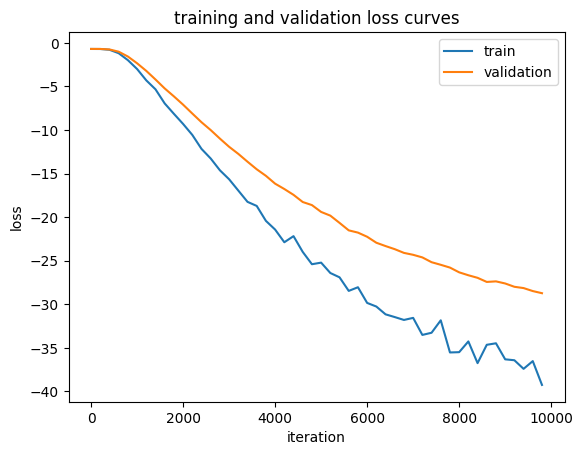

In [25]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [26]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -32.06158, test_recall@20: 0.14853, test_precision@20: 0.04607, test_ndcg@20: 0.11365


## Make New Recommendatios for a Given User

In [27]:
model.eval()
# df = pd.read_csv(movie_path)
movieid_title = pd.Series(df.title.values,index=df.movieId).to_dict()
movieid_genres = pd.Series(df.genres.values,index=df.movieId).to_dict()

user_pos_items = get_user_positive_items(edge_index)

AttributeError: 'DataFrame' object has no attribute 'title'

In [ ]:
def make_predictions(user_id, num_recs):
    user = user_mapping[user_id]
    e_u = model.users_emb.weight[user]
    scores = model.items_emb.weight @ e_u

    values, indices = torch.topk(scores, k=len(user_pos_items[user]) + num_recs)

    movies = [index.cpu().item() for index in indices if index in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some movies that user {user_id} rated highly")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

    print()

    movies = [index.cpu().item() for index in indices if index not in user_pos_items[user]][:num_recs]
    movie_ids = [list(movie_mapping.keys())[list(movie_mapping.values()).index(movie)] for movie in movies]
    titles = [movieid_title[id] for id in movie_ids]
    genres = [movieid_genres[id] for id in movie_ids]

    print(f"Here are some suggested movies for user {user_id}")
    for i in range(num_recs):
        print(f"title: {titles[i]}, genres: {genres[i]} ")

In [ ]:
USER_ID = 1
NUM_RECS = 10

make_predictions(USER_ID, NUM_RECS)